In [50]:
%load_ext autoreload
%autoreload 2

import mlflow
from mlflow.models import infer_signature

# from mlflow import MlflowClient
# client = MlflowClient()

# # Delete a registered model along with all its versions
# client.delete_registered_model(name="test_breast_cancer")

import logging

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
mlflow.models.list_evaluators()

['default', 'fairness_evaluator']

In [52]:
# Load the diabetes dataset from sklearn
X, y = datasets.load_breast_cancer(return_X_y=True)

In [53]:
X.shape

(569, 30)

In [54]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [55]:
# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 3000,
    "random_state": 33,
}

In [56]:
# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=33)

In [57]:
# Predict on the test set
y_pred = lr.predict(X_test)

In [58]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.956140350877193


In [59]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [60]:
# Create a new MLflow Experiment
mlflow.set_experiment("breast_cancer_test")

2024/09/10 17:56:47 INFO mlflow.tracking.fluent: Experiment with name 'breast_cancer_test' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/470695359105762589', creation_time=1726009007950, experiment_id='470695359105762589', last_update_time=1726009007950, lifecycle_stage='active', name='breast_cancer_test', tags={}>

In [61]:
logging.getLogger("mlflow").setLevel(logging.DEBUG)

In [62]:
# Infer the model signature
signature = infer_signature(X_train, lr.predict(X_train))

In [63]:
# Build the Evaluation Dataset from the test set
eval_data = pd.DataFrame(X_test)
eval_data['label'] = y_test

Registered model 'breast_cancer_test' already exists. Creating a new version of this model...
2024/09/10 17:59:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: breast_cancer_test, version 2
Created version '2' of model 'breast_cancer_test'.
/home/sudoris/anaconda3/envs/argos-fairness-evaluator/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://

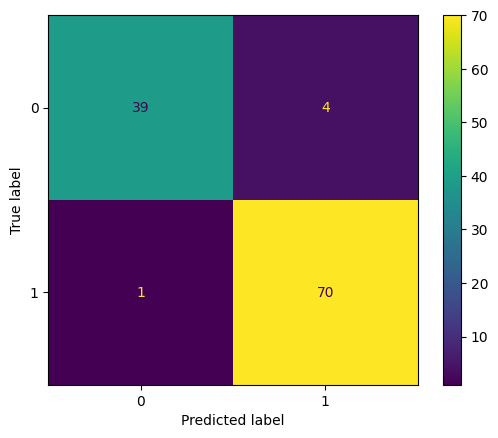

In [66]:
###### # Log to mlflow tracking server
# with mlflow.start_run():
#     # Log the hyperparameters
#     mlflow.log_params(params)

#     # Log the loss metric
#     mlflow.log_metric("accuracy", accuracy)

#     # Set a tag that we can use to remind ourselves what this run was for
#     mlflow.set_tag("Training Info", "Basic LR model for breast cancer data")

#     # Log the model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=lr,
#         artifact_path="breast_cancer_model",
#         signature=signature,
#         input_example=X_train,
#         registered_model_name="test_breast_cancer",
#     )
    
    
# Log to mlflow tracking server using custom fairness_evaluator plugin
with mlflow.start_run() as run:
    
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="breast_cancer_test",
        signature=signature,
        input_example=X_train,
        registered_model_name="breast_cancer_test",
    )
    
    model_uri = mlflow.get_artifact_uri("breast_cancer_test")

    # Evaluate the logged model
    evaluate_results = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["fairness_evaluator"],
    )    

In [65]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_test)

breast_cancer_feature_names = datasets.load_breast_cancer().feature_names

results = pd.DataFrame(X_test, columns=breast_cancer_feature_names)
results['actual'] = y_test
results['predicted'] = predictions

results[:4]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,actual,predicted
0,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,96.05,677.9,0.1426,0.2378,0.2671,0.1015,0.3014,0.08750,1,1
1,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,165.90,1866.0,0.1193,0.2336,0.2687,0.1789,0.2551,0.06589,0,0
2,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,124.90,1156.0,0.1546,0.2394,0.3791,0.1514,0.2837,0.08019,0,0
3,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,89.61,515.8,0.1450,0.2629,0.2403,0.0737,0.2556,0.09359,1,1
